In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
words = open("../names.txt", 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}


In [13]:
""" 
BLOCK SIZE 
maximum number of tokens the model can process in 
a single input sequence at one time.
"""
block_size = 3
X, Y = [], []
for w in words:
    context = [0] * block_size
    # print("context", context)
    for ch in w + '.':
        ix = stoi[ch]
        # print(ch, ix)
        X.append(context)
        Y.append(ix)
        # print("X",X, "Y", Y)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [18]:
X1 = X[3:5]
X1

tensor([[ 5, 13, 13],
        [13, 13,  1]])

In [ ]:
"""
CREATE EMBEDDING CHANNEL
C = Embedding Matrix or Lookup Table : 
    number of embeddings x embedding dimension

X will be replaced to C embeddings
Embedding[words x batch_size] = words, batch_size, embedding_dimension
"""
C = torch.randn(27, 2)
emb_raw = C[X]
emb_raw.size()

# concatanate batch and embeddings to make it two dimensional

emb = emb_raw.view(emb_raw.size(0), -1)

In [ ]:
# set up weights
input_size = emb.size(1)
hidden_layer1 = 100
output_layer = C.size(0)
W1 = torch.randn(input_size, hidden_layer1)
b1 = torch.randn(hidden_layer1)
W2 = torch.randn(hidden_layer1, output_layer)
b2 = torch.randn(output_layer)

#Layer
tanh = torch.nn.Tanh()

In [ ]:
# forward
logits = emb @ W1 + b1
logits = tanh(logits)
logits = logits @ W2 + b2
probs = torch.softmax(logits, dim=1)
loss = -probs[torch.arange(emb.size(0)), Y].log().mean()


tensor(18.2875)

### MODEL CONSTRUCT

In [105]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import random


In [142]:
words = open('../names.txt', 'r').read().splitlines()

chrs = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chrs)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}


In [191]:
### PARAMETERS
block_size = 3
hidden_layer = 200
output_layer = len(stoi)
max_step = 10000
g = torch.Generator().manual_seed(654646)
C = torch.randn((len(stoi), 10), generator=g)
W1 = torch.randn((block_size*C.size(1),hidden_layer), generator=g)
b1 = torch.randn(hidden_layer, generator=g)
W2 = torch.randn((hidden_layer, output_layer), generator=g)
b2 = torch.randn(output_layer, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
num_param = sum(p.numel() for p in parameters)
num_param

11897

In [192]:
""" DATA SET DEVELOPMENT """

def build_dataset(words, block_size):
    block_size = block_size
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for chr in w + '.':
            ix = stoi[chr]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(66)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1], block_size)
X_val, Y_val = build_dataset(words[n1:n2], block_size)
X_test, Y_ttest = build_dataset(words[n2:], block_size)



In [193]:
""" MODEL DEVELOPMENT """

### learning rate maximization  
# You're sweeping learning rates from 10⁻³ = 0.001 to 10⁰ = 1.0.
lre = torch.linspace(-2.5, -1, max_step)
lrs = 10**lre

lri = []
lossi = []
loss_vali = []
for step in range(max_step):

    # minibatch
    batch_index = torch.randint(0, X_train.size(0), (32,))

    # forward pass
    emb = C[X_train[batch_index]].view(-1, block_size*C.size(1))
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train[batch_index])

    # validation
    emb_val = C[X_val].view(-1, block_size*C.size(1))
    h_val = torch.tanh(emb_val @ W1 + b1)
    logits_val = h_val @ W2 + b2
    loss_val = F.cross_entropy(logits_val, Y_val)
    loss_vali.append(loss_val.item())

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.01
    # lr = lrs[step]
    for p in parameters:
        p.data += -lr * p.grad
    
    # stats tracker
    # lri.append(lre[step])
    lossi.append(loss.item())


In [195]:
loss

tensor(2.8123, grad_fn=<NllLossBackward0>)

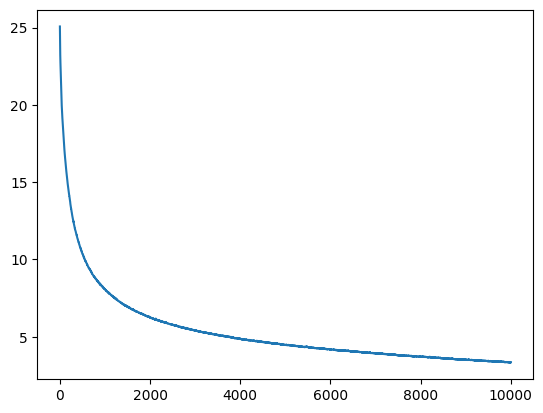

In [194]:
# plt.plot(lri, lossi)
plt.plot(loss_vali)

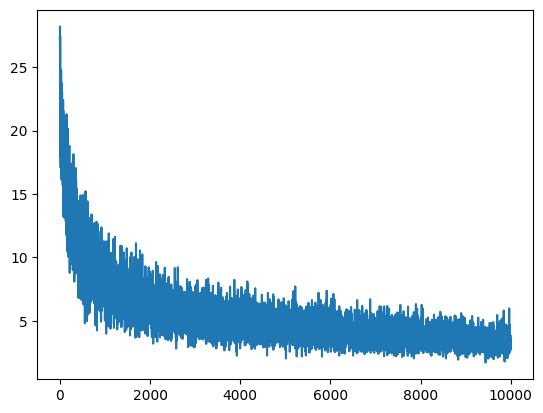

In [ ]:
plt.plot(lossi)

In [199]:
C.shape

torch.Size([27, 10])

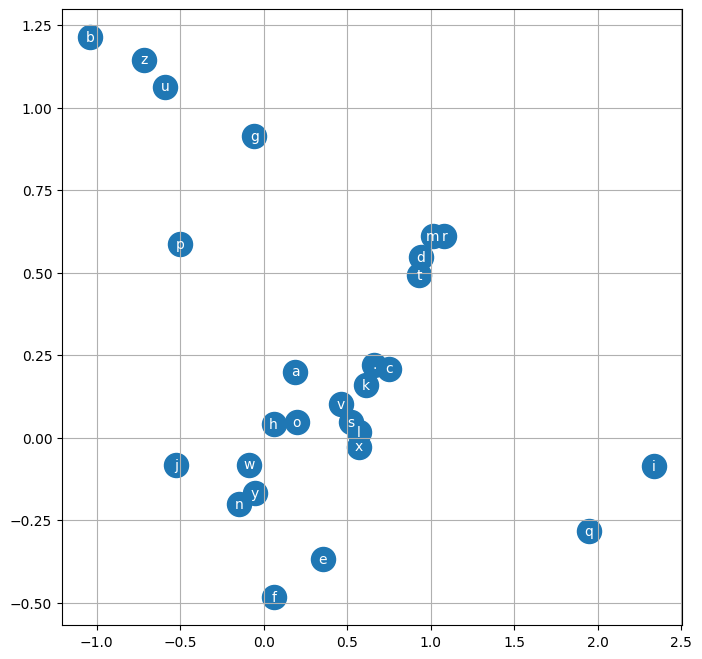

In [197]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=300)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')